# Epix10ka


In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
import h5py
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
# import seaborn as sns

DPATH = "/reg/d/psdm/mfx/mfxx32516"
RUN = 346
 
# data file
dfile = h5py.File(DPATH + '/hdf5/smalldata/run_%d.h5' % (RUN), 'r')

epix10ka_active = []  # list to store current epix10ka cams in setup
for key,val in dict(dfile).iteritems():
    print key, val
    if "epix10ka" in key.lower():
        cam, idx = key.split("_")
        epix10ka_active.append(int(idx))

acqiris_0 <HDF5 group "/acqiris_0" (2 members)>
gas_detector <HDF5 group "/gas_detector" (6 members)>
event_time <HDF5 dataset "event_time": shape (28697,), type "<i8">
wave8_0 <HDF5 group "/wave8_0" (1 members)>
fiducials <HDF5 dataset "fiducials": shape (28697,), type "<i8">
bmon_0 <HDF5 group "/bmon_0" (1 members)>
Epix10ka_0 <HDF5 group "/Epix10ka_0" (3 members)>
Epix10ka_1 <HDF5 group "/Epix10ka_1" (3 members)>
evr <HDF5 group "/evr" (2 members)>
phase_cav <HDF5 group "/phase_cav" (4 members)>
ebeam <HDF5 group "/ebeam" (5 members)>


ePix10ka_0 mask


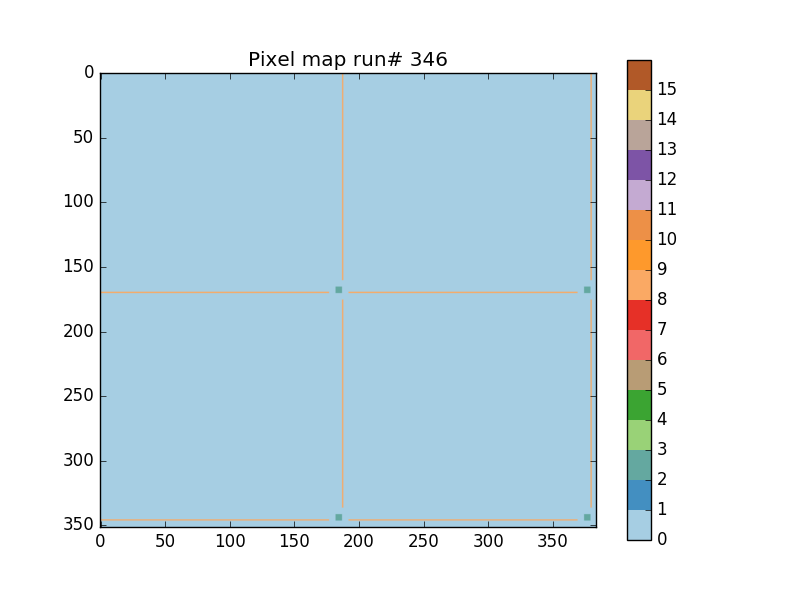

ePix10ka_1 mask


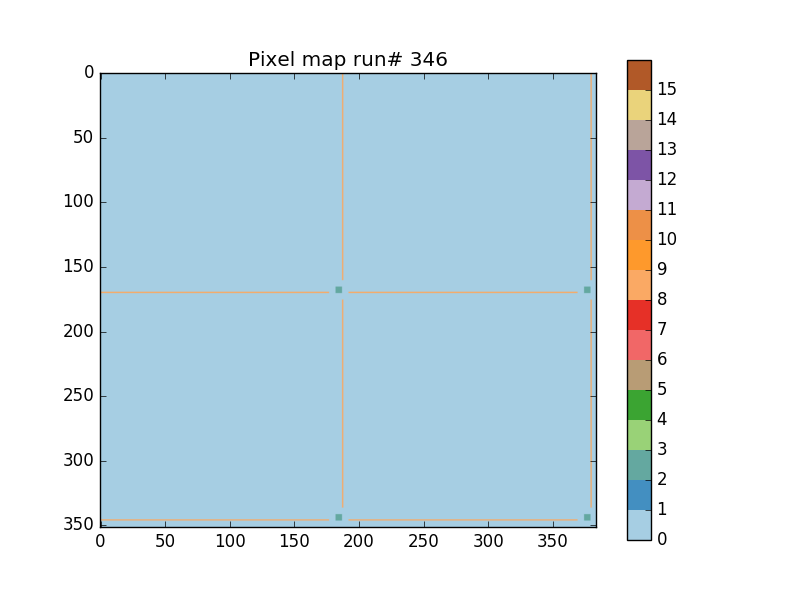

In [15]:
# visual display of pixel map
from IPython.display import Image
from IPython.core.display import HTML 

for cam in epix10ka_active:
    print("ePix10ka_%d mask" % (cam))
    display(Image(filename= DPATH + "/results/abunimeh/2/configs/r%d_%d.conf.png" % (RUN, cam)))

In [4]:
# config dump. good for searching strings
for cam in epix10ka_active:
    print("ePix10ka_%d config" % (cam))
    display(HTML(DPATH + "/results/abunimeh/2/configs/r%d_%d.conf" % (RUN, cam)))

ePix10ka_0 config


ePix10ka_1 config


In [5]:
# time slice. good to get rid of unwanted frames
tmin = 0
tmax = dfile['/event_time'].shape[0]
print(tmax)

28697


In [6]:
# acqiris data
acqiris_wf = dfile['/acqiris_0/waveforms']
acqiris_t = dfile['/acqiris_0/times']

print(acqiris_wf.shape)
print(acqiris_t.shape)

(28697, 8, 12000)
(28697, 8, 12000)


In [7]:
# epix10ka data
epix10ka_0_raw_f = dfile['/Epix10ka_0/raw']
epix10ka_0_env_f = dfile['/Epix10ka_0/env']
epix10ka_0_calib_f = dfile['/Epix10ka_0/calib']

print(epix10ka_0_raw_f.shape)
print(epix10ka_0_env_f.shape)
print(epix10ka_0_calib_f.shape)

epix10ka_1_raw_s = dfile['/Epix10ka_1/raw']
epix10ka_1_env_s = dfile['/Epix10ka_1/env']
epix10ka_1_calib_s = dfile['/Epix10ka_1/calib']

print(epix10ka_1_raw_s.shape)
print(epix10ka_1_env_s.shape)
print(epix10ka_1_calib_s.shape)

(28697, 352, 384)
(28697, 2, 192)
(28697, 4, 384)
(28697, 352, 384)
(28697, 2, 192)
(28697, 4, 384)


In [8]:
# evr codes
evr_40 = dfile['/evr/code_40']
evr_162 = dfile['/evr/code_162']

# BYKIK, offbyone
e40 = evr_40.value
e40_idx = np.argwhere(e40 == 1).flatten()
print(e40_idx.shape)

e162 = evr_162.value
e162_idx = np.argwhere(e162 == 1).flatten()
print(e162_idx.shape)
mask = np.ones(e162.shape[0], dtype=bool)
mask[e162_idx] = False  # frames when beam exists
print(mask.shape)
mask = mask[tmin:tmax]  # we only care about time slice of interest
dmask = np.invert(mask) # dark frames -- when beam doesnt exists
print(dmask.shape)

(28697,)
(1688,)
(28697,)
(28697,)


In [9]:
# beam monitor data
i0 = dfile['/bmon_0/flux']
print(i0.shape)

(28697, 16)


In [10]:
# beam monitor wave8 data. more details
i0 = dfile['/wave8_0/data']
print(i0.shape)

(28697, 16, 4096)


In [11]:
# we are only interested in i0 peak amplitude when beam is not kicked
i0 = dfile['/bmon_0/flux'][tmin:tmax, :]
i0 = i0[mask]
print(i0.shape)

(27009, 16)


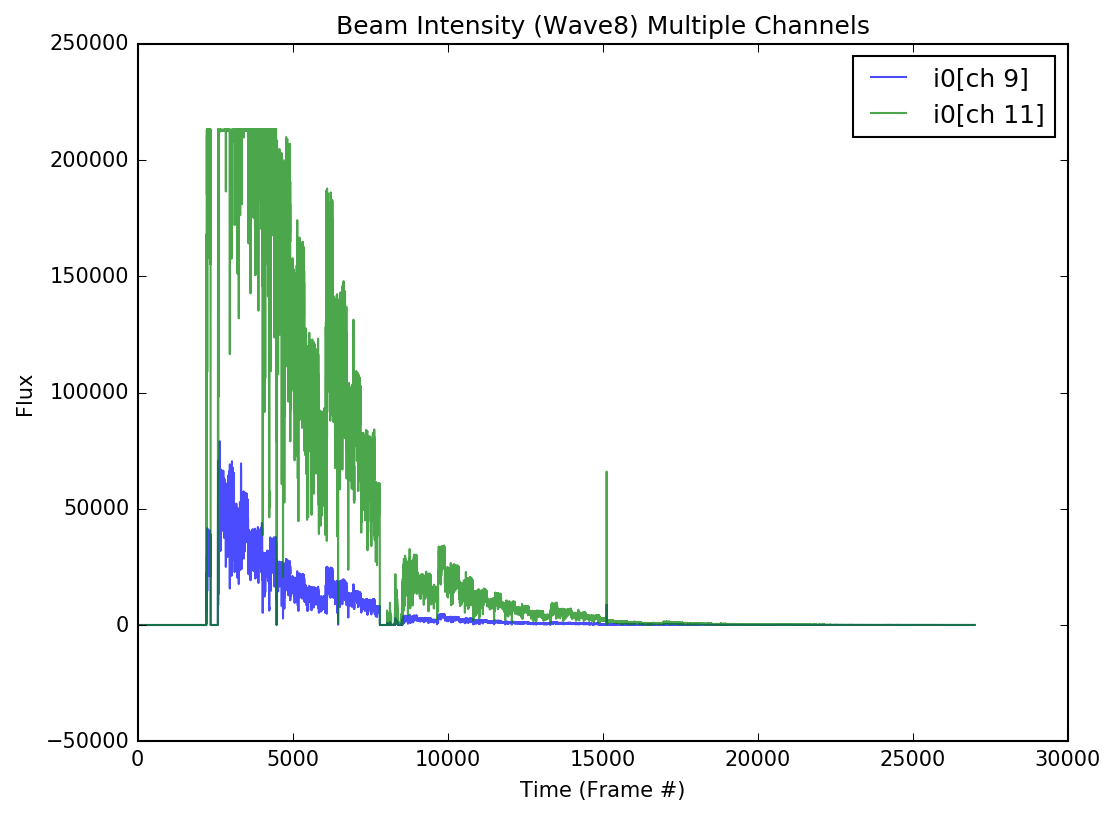

(27009,)


In [12]:
plt.figure(1,figsize=(8,6),dpi=150)

# plt.plot(i0[tmin:tmax,8], alpha=0.7, label='i0[ch 8]')  # too low
plt.plot(i0[tmin:tmax,9], alpha=0.7, label='i0[ch 9]')  # sat
#plt.plot(i0[tmin:tmax,10], '.', alpha=0.7, label='i0[ch 10]')  # OK
plt.plot(i0[tmin:tmax,11], alpha=0.7, label='i0[ch 11]')  # sat
#plt.plot(i0[tmin:tmax,12], alpha=0.7, label='i0[ch 12]')  # too low
#plt.plot(i0[tmin:tmax,13], alpha=0.7, label='i0[ch 13]')  # sat
#plt.plot(i0[tmin:tmax,14], alpha=0.7, label='i0[ch 14]') # sat big time
#plt.plot(i0[tmin:tmax,15], '.', alpha=0.7, label='i0[ch 15]')  # OK

plt.xlabel('Time (Frame #)')
plt.ylabel('Flux')
plt.title('Beam Intensity (Wave8) Multiple Channels')
plt.legend()
plt.show()
w8ch = 11
i0_ch = i0[:,w8ch]
print(i0_ch.shape)

In [ ]:
plt.figure(1,figsize=(8,6),dpi=150)
plt.hist(i0_ch.ravel(), bins='auto', histtype='step')
plt.xlabel('Beam Intensity (flux)')
plt.ylabel('Count')
plt.title('Beam Intensity Histogram (CH%d)' % (w8ch))
plt.show()

# Camera = 0 = Spaghetti

In [ ]:
raw = epix10ka_0_raw_f[tmin:tmax, :, :]
print(raw.shape)
if e162_idx.size:
    dark = raw[dmask]
    print(dark.shape)
iasic = raw[mask]
print(iasic.shape)

In [ ]:
# Camera = Spaghetti
# if dark frames exist plot them
if e162_idx.size:
    img_avg = np.average(dark, 0)  # mean across multiple frames
    img_std = np.std(dark, 0)  # std across multiple frames

    print('Baseline average: %f' % (img_avg.mean()))
    print('Noise average: %f' % (img_std.mean()))

    f, ax = plt.subplots(2, 2)
    f.suptitle("Run %d, # dark frames: %d" % (RUN, dark.shape[0]), fontsize=14)
    f.set_size_inches(14, 14)
    f.set_dpi(150)
    
    # mean
    im0 = ax[0, 0].imshow(img_avg, cmap=cm.plasma)
    ax[0, 0].set_title('Mean')
    ax[0, 0].set_xlabel('Column')
    ax[0, 0].set_ylabel('Row')
    f.colorbar(im0, ax=ax[0, 0])
    n, bins, patches = ax[0, 1].hist(img_avg.ravel(), bins='auto', histtype='step')
    ax[0, 1].set_title('Mean Histrogram')
    ax[0, 1].set_xlabel('ADC Count')
    ax[0, 1].set_ylabel('Frequency')

    # Gaussian fit
    (mu, sigma) = norm.fit(img_avg.ravel())
    ax[0, 1].text(1., 1., r'$\mu=%.3f,\ \sigma=%.3f$' % (mu, sigma),
                  transform=ax[0, 1].transAxes, horizontalalignment='right',
                  verticalalignment='top')
    normscale = np.sum(n * np.diff(bins))
    y = mlab.normpdf(bins, mu, sigma) * normscale  # scale it to match height
    ax[0, 1].plot(bins, y, 'r--')
    # limit x-axis
    ax[0, 1].set_xlim((mu-800, mu+300))
    # ax[0, 1].set_xlim((mu-5*sigma, mu+5*sigma))    
    
    # STD
    im1 = ax[1, 0].imshow(img_std, cmap=cm.plasma)
    ax[1, 0].set_title('Standard Deviation')
    ax[1, 0].set_xlabel('Column')
    ax[1, 0].set_ylabel('Row')
    f.colorbar(im1, ax=ax[1, 0])
    n, bins, patches = ax[1, 1].hist(img_std.ravel(), bins='auto', histtype='step')
    ax[1, 1].set_title('Standard Deviation Histogram')
    ax[1, 1].set_xlabel('ADC Count')

    # Gaussian fit
    (mu, sigma) = norm.fit(img_std.ravel())
    ax[1, 1].text(1., 1., r'$\mu=%.3f,\ \sigma=%.3f$' % (mu, sigma),
                  transform=ax[1, 1].transAxes, horizontalalignment='right',
                  verticalalignment='top')
    normscale = np.sum(n * np.diff(bins))
    y = mlab.normpdf(bins, mu, sigma) * normscale  # scale it to match height
    ax[1, 1].plot(bins, y, 'r--')
    # limit x-axis
    ax[1, 1].set_ylabel('Frequency')
    ax[1, 1].set_xlim((0, 50))
    # ax[1, 1].set_xlim((mu-5*sigma, mu+5*sigma))
    plt.show()
    
    
    odd_mpixels = np.argwhere(img_avg > img_avg.mean()*2)
    print('%d pixel(s) have a baseline average twice as big as the other pixels:' % (odd_mpixels.shape[0]))
    print(odd_mpixels)
    if (odd_mpixels.size < 25):
        plt.figure(1,figsize=(8,6),dpi=150)
        for pm in odd_mpixels:
            plt.plot(iasic[:,pm[0], pm[1]], alpha=0.7, label='pm (%d,%d)' % (pm[0], pm[1]))

        plt.xlabel('Time (Frame #)')
        plt.ylabel('Amplitude (ADU)')
        plt.title('Pixels with 2x baseline than others')
        plt.legend()
        plt.show()
        
    odd_spixels = np.argwhere(img_std > img_std.mean()*1.5)
    print('%d pixel(s) have a noise 1.5x more than the other pixels:' % (odd_spixels.shape[0]))
    print(odd_spixels)
    
    if (odd_spixels.size < 25):
        plt.figure(1,figsize=(8,6),dpi=150)
        for ps in odd_spixels:
            plt.plot(iasic[:,ps[0], ps[1]], alpha=0.7, label='ps (%d,%d)' % (ps[0], ps[1]))

        plt.xlabel('Time (Frame #)')
        plt.ylabel('Amplitude (ADU)')
        plt.title('Pixels with 1.5x std than others')
        plt.legend()
        plt.show()

In [ ]:
px_x = 200
px_y = 200

pa_x = 346
pa_y = 100

px_lim = iasic[:,px_x,px_y] & 0x3FFF
px_lim2 = iasic[:, pa_x, pa_y] & 0x3FFF
plt.figure(1,figsize=(8,6),dpi=150)
plt.scatter(i0_ch, px_lim, s=5, alpha=0.5, marker='o', label='(%d,%d)' % (px_x, px_y))
plt.scatter(i0_ch, px_lim2, s=5, alpha=0.5, marker='o', color='r', label='(%d,%d)' % (pa_x, pa_y))
plt.xlabel('Beam Intensity (Flux)')
plt.ylabel('Amplitude (ADU)')
plt.title('Pixel reponse in frames[%d:%d]' % (tmin, tmax))
plt.legend()
plt.show()

In [ ]:
plt.figure(1,figsize=(8,6),dpi=150)

i0_ch_sorted_idx = np.argsort(i0_ch)
i0_ch_sorted = i0_ch[i0_ch_sorted_idx]
y = px_lim[i0_ch_sorted_idx]
x = i0_ch_sorted
plt.scatter(x, y, s=1, alpha=0.7, marker='o', color='b', label='(%d,%d)' % (px_x, px_y))
# plt.plot(y)
plt.xlabel('Beam (flux)')
plt.ylabel('Amplitude (ADU)')
plt.title('Pixel (%d,%d) Response to different beam intensities, run%d' % (px_x, px_y, RUN))

# fitting
# switch point
swtpt = 3000
swtpt_idx = (np.abs(x - swtpt)).argmin()
# high gain
x_h = x[:swtpt_idx]
y_h = y[:swtpt_idx]

slope, intercept, r_value, p_value, std_err = stats.linregress(x_h,y_h)
print('### high gain ###')
print('slope %.4f' % (slope))
print('intercept %.3f' % (intercept))
print('R2 %.3f' % (r_value**2))
print('p %.3f' % (p_value))
print('std_err %.3f' % (std_err))
# make x longer
#x = np.linspace(f0-50, f1+50, num=y.shape[0])
plt.plot(x_h, intercept+slope*x_h, 'k-', linewidth=2, label='hg linear fit: ' +r'$%5.2fx+%5.2f$' % (slope, intercept))

# low gain
swtpt = 3000
swtpt_idx = (np.abs(x - swtpt)).argmin()
x_l = x[swtpt_idx:]
y_l = y[swtpt_idx:]

slope, intercept, r_value, p_value, std_err = stats.linregress(x_l,y_l)
print('### low gain ###')
print('slope %.4f' % (slope))
print('intercept %.3f' % (intercept))
print('R2 %.3f' % (r_value**2))
print('p %.3f' % (p_value))
print('std_err %.3f' % (std_err))
# make x longer
#x = np.linspace(f0-50, f1+50, num=y.shape[0])
plt.plot(x_l, intercept+slope*x_l, 'r-', linewidth=2, label='lg linear fit: ' +r'$%5.2fx+%5.2f$' % (slope, intercept))

# plt.xlim(0,5000)
plt.legend(frameon=False)
plt.show()

In [ ]:
plt.figure(1,figsize=(8,6),dpi=150)

i0_ch_sorted_idx = np.argsort(i0_ch)
i0_ch_sorted = i0_ch[i0_ch_sorted_idx]
y = px_lim2[i0_ch_sorted_idx]
x = i0_ch_sorted
plt.scatter(x, y, s=1, alpha=0.7, marker='o', color='b', label='(%d,%d)' % (pa_x, pa_y))
# plt.plot(y)
plt.xlabel('Beam (flux)')
plt.ylabel('Amplitude (ADU)')
plt.title('FLG Pixel (%d,%d) response, run%d' % (pa_x, pa_y, RUN))

# fitting
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('### low gain ###')
print('slope %.4f' % (slope))
print('intercept %.3f' % (intercept))
print('R2 %.3f' % (r_value**2))
print('p %.3f' % (p_value))
print('std_err %.3f' % (std_err))
# make x longer
#x = np.linspace(f0-50, f1+50, num=y.shape[0])
plt.plot(x, intercept+slope*x, 'r-', linewidth=2, label='lg linear fit: ' +r'$%5.2fx+%5.2f$' % (slope, intercept))

#plt.xlim(0,10000)
plt.legend(frameon=False)
plt.show()

# Epix10ka Env Rows
0. Strong back cold side temperature in Celcius degree * 100. Signed data.
1. Ambient temperature in Celcius degree * 100. Signed data.
2. Relative humidity in percent * 100. Signed data.
3. ASIC analog current in mA. Unsigned data.
4. ASIC digital current in mA. Unsigned data.
5. Detector guard ring current in uA. Unsigned data.
6. Invalid data
7. Analog input voltage in mV. Unsigned data.
8. Digital input voltage in mV. Unsigned data.

In [ ]:
# for all frames including darks
envdata = epix10ka_0_env_f.value
print(envdata.shape)

In [ ]:
# 0. Strong back cold side temperature in Celcius degree * 100. Signed data.
sbcs_temp = envdata[:, 1, 0].astype(np.int32)/100.0
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Strong Back Cold Side Temperature')
plt.xlabel('Frame number')
plt.ylabel('Temperature (C)')
plt.plot(sbcs_temp)
plt.show()

In [ ]:
# 1. Ambient temperature in Celcius degree * 100. Signed data.
amb_temp = envdata[:, 1, 1].astype(np.int32)/100.0
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Ambient Temperature')
plt.xlabel('Frame number')
plt.ylabel('Temperature (C)')
plt.plot(amb_temp)
plt.show()

In [ ]:
# 2. Relative humidity in percent * 100. Signed data.
humidity = envdata[:, 1, 2].astype(np.int32)/100.0
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Relative Humidity')
plt.xlabel('Frame number')
plt.ylabel('Humidity (%)')
plt.plot(humidity)
plt.show()

In [ ]:
# 3. ASIC analog current in mA. Unsigned data.
asic_ana_i = envdata[:, 1, 3].astype(np.uint32)
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('ASIC Analog Current')
plt.xlabel('Frame number')
plt.ylabel('Current (mA)')
plt.plot(asic_ana_i)
plt.show()

In [ ]:
# 4. ASIC digital current in mA. Unsigned data.
asic_dig_i = envdata[:, 1, 4].astype(np.uint32)
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('ASIC Digital Current')
plt.xlabel('Frame number')
plt.ylabel('Current (mA)')
plt.plot(asic_dig_i)
plt.show()

In [ ]:
# 5. Detector guard ring current in uA. Unsigned data.
det_gring_i = envdata[:, 1, 5].astype(np.uint32)
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Detector Guard Ring Current')
plt.xlabel('Frame number')
plt.ylabel(r'Current ($\mu$A)')
plt.plot(det_gring_i)
plt.show()

In [ ]:
# 7. Analog input voltage in mV. Unsigned data.
ana_v = envdata[:, 1, 7].astype(np.uint32)
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Analog Input Voltage')
plt.xlabel('Frame number')
plt.ylabel('Voltage (mV)')
plt.plot(ana_v)
plt.show()

In [ ]:
# 8. Digital input voltage in mV. Unsigned data.
dig_v = envdata[:, 1, 8].astype(np.uint32)
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Digital Input Voltage')
plt.xlabel('Frame number')
plt.ylabel('Voltage (mV)')
plt.plot(dig_v)
plt.show()

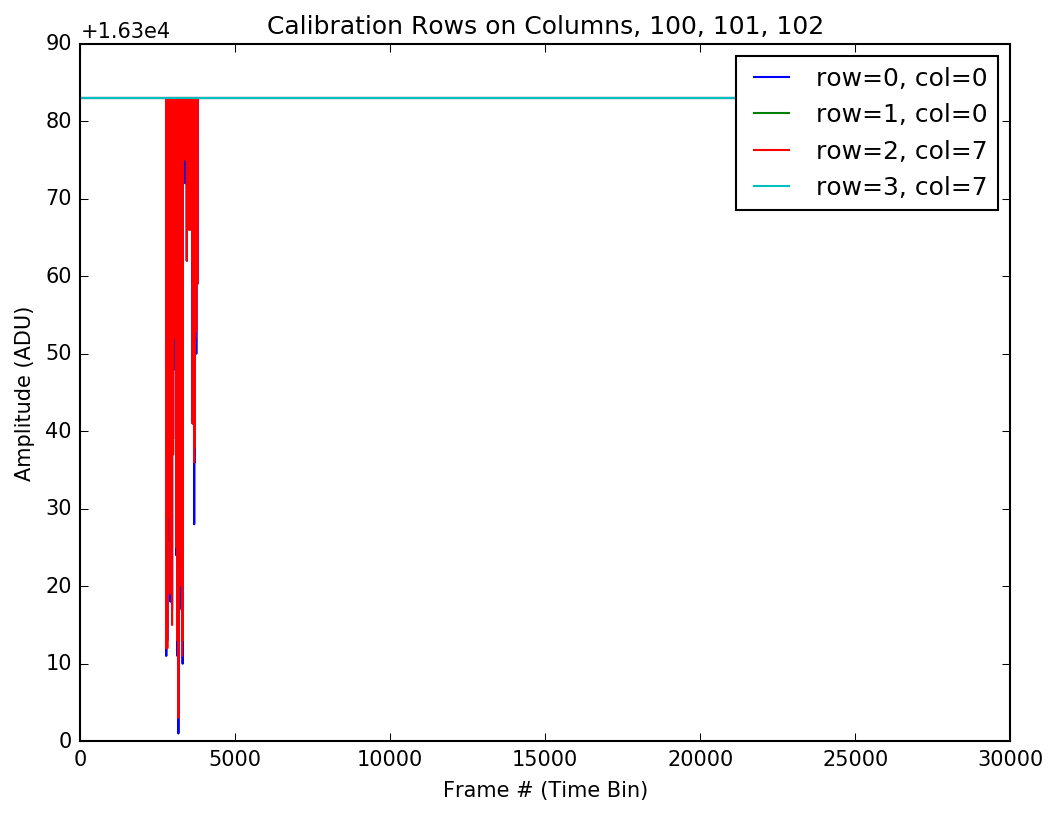

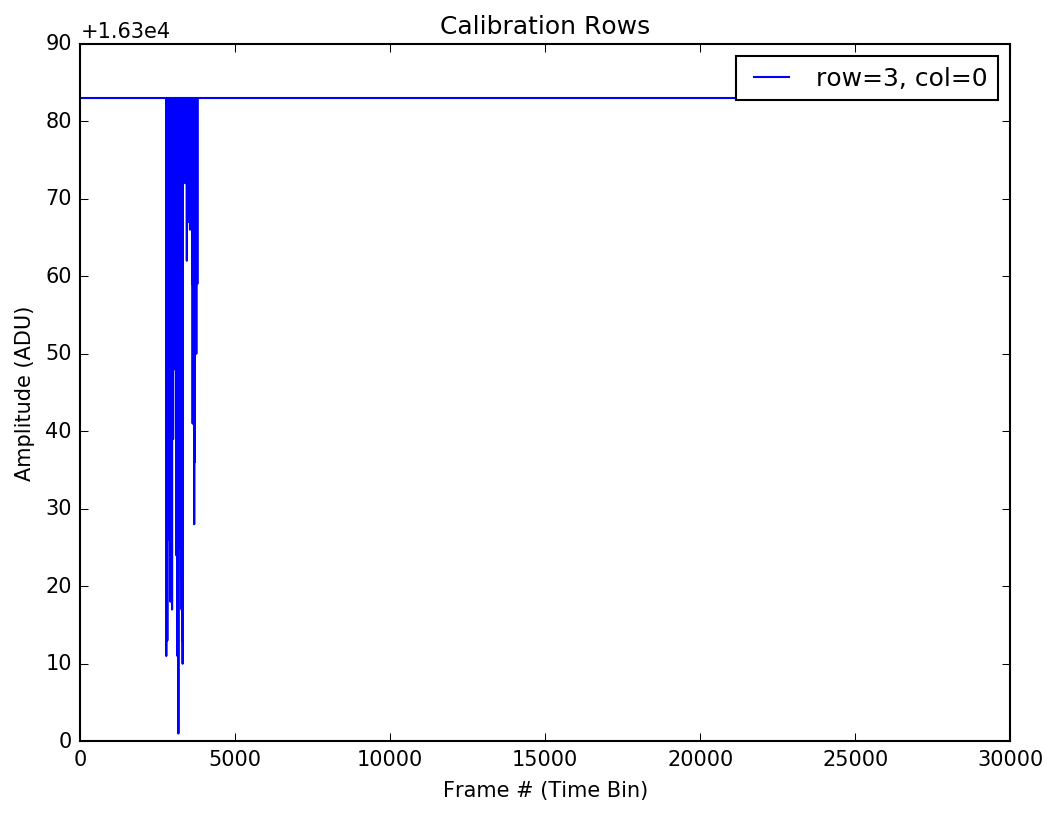

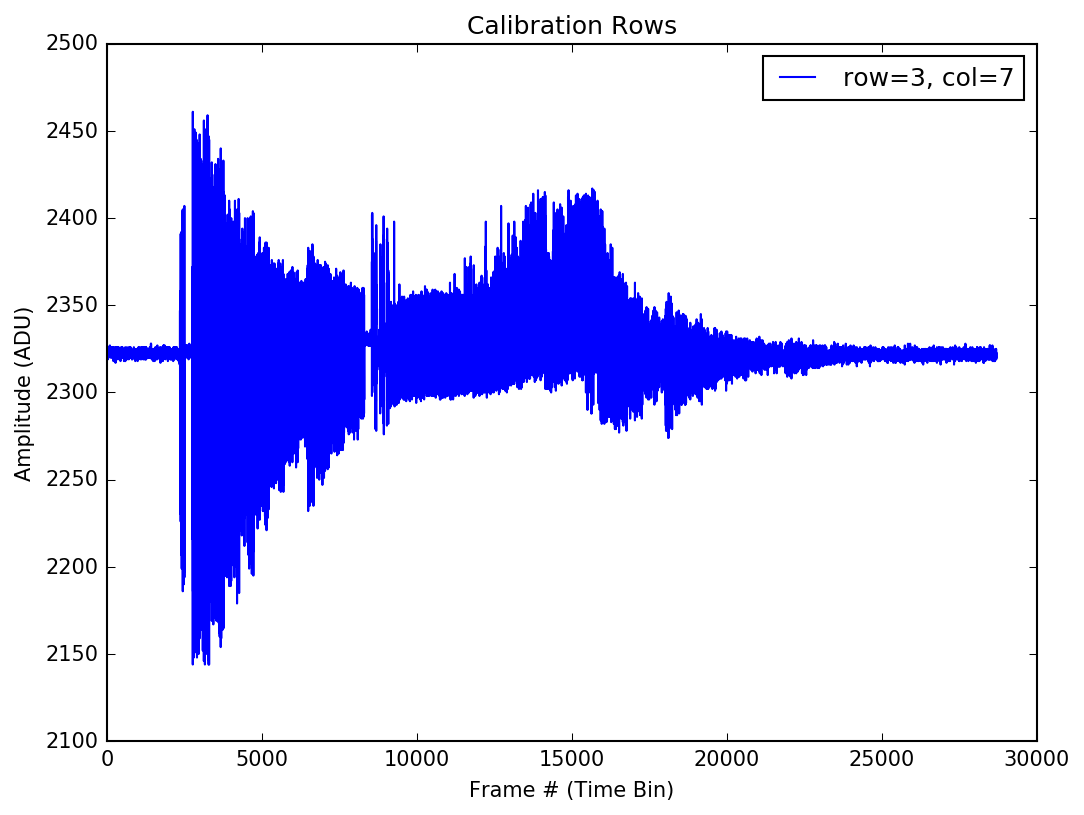

In [21]:
# calibration rows
plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows on Columns, 100, 101, 102')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']

# calcol = epix10ka_0_calib_f[:,:,100] & 0x3FFF
# for idx, lbl in enumerate(labels):
#     if idx == 0 or idx == 1:
#         # print calcol[:, idx]
#         pass
#     else:
#         plt.plot(calcol[:, idx], '--' ,label=lbl + ', col=100')
        

calcol = epix10ka_0_calib_f[:,:,0] & 0x3FFF
for idx, lbl in enumerate(labels):
    if idx == 0 or idx == 1:
        # print calcol[:, idx]
        # pass
        plt.plot(calcol[:, idx] ,label=lbl + ', col=0')
    else:
        pass
        # plt.plot(calcol[:, idx] ,label=lbl + ', col=0')
        
calcol = epix10ka_0_calib_f[:,:,7] & 0x3FFF
for idx, lbl in enumerate(labels):
    if idx == 0 or idx == 1:
        # print calcol[:, idx]
        pass
        # plt.plot(calcol[0:1000, idx] ,label=lbl + ', col=7')
    else:
        # pass
        plt.plot(calcol[:, idx] ,label=lbl + ', col=7')

# calcol102 = epix10ka_0_calib_f[:,:,102] & 0x3FFF
# for idx, lbl in enumerate(labels):
#     if idx == 0 or idx == 1:
#         # print calcol[:, idx]
#         pass
#     else:
#         plt.plot(calcol[:, idx], ':' ,label=lbl + ', col=102')

# calcol103 = epix10ka_0_calib_f[:,:,103] & 0x3FFF
# for idx, lbl in enumerate(labels):
#     if idx == 0 or idx == 1:
#         # print calcol[:, idx]
#         pass
#     else:
#         plt.plot(calcol[:, idx], '.' ,label=lbl + ', col=103')
        
plt.legend()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol0 = epix10ka_0_calib_f[:,0,0] & 0x3FFF
plt.plot(calcol0,label=lbl + ', col=0')
plt.legend()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol7 = epix10ka_0_calib_f[:,0,7] & 0x3FFF
plt.plot(calcol7,label=lbl + ', col=7')
plt.legend()
plt.show()

Epix10ka_1


### [Epix10ka_1] RUN 346 config ###
R0Mode: 1
SyncDelay: 30
SyncMode: 0
SyncWidth: 30
acqToAsicR0Delay: 14032
adcClkHalfT: 1
adcPipelineDelay: 32
adcPipelineDelay0: 32
adcPipelineDelay1: 32
adcPipelineDelay2: 32
adcPipelineDelay3: 32
adcReadsPerPixel: 1
adcStreamMode: 0
analogCardId0: 2996154369
analogCardId1: 218103833
asicAcq: 0
asicAcqControl: 0
asicAcqLToPPmatL: 200
asicAcqWidth: 2500
asicGR: 0
asicGRControl: 0
asicMask: 15
asicPPmatToReadout: 0
asicPpbe: 0
asicPpbeControl: 0
asicPpmat: 1
asicPpmatControl: 1
asicR0: 0
asicR0ClkControl: 0
asicR0Control: 0
asicR0ToAsicAcq: 10000
asicR0Width: 30
asicRoClk: 0
asicRoClkHalfT: 5
asics_shape: [4]
baseClockFrequency: 1048576
calibPixelConfigArray: [[3 3 3 3 3 3 3 0 3 0 3 0 3 0 0 3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0
  3 3 0 3 3 3 3 0 3 3 0 3 0 3 3 0 3 3 0 0 3 0 0 3 0 0 0 3 3 3 0 0 0 0 3 0 3
  3 3 3 3 0 0 3 0 3 0 3 3 3 0 0 3 3 0 3 0 0 0 3 3 3 3 3 3 3 0 3 0 3 0 3 0 0
  3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0 3 3 0 3 3 

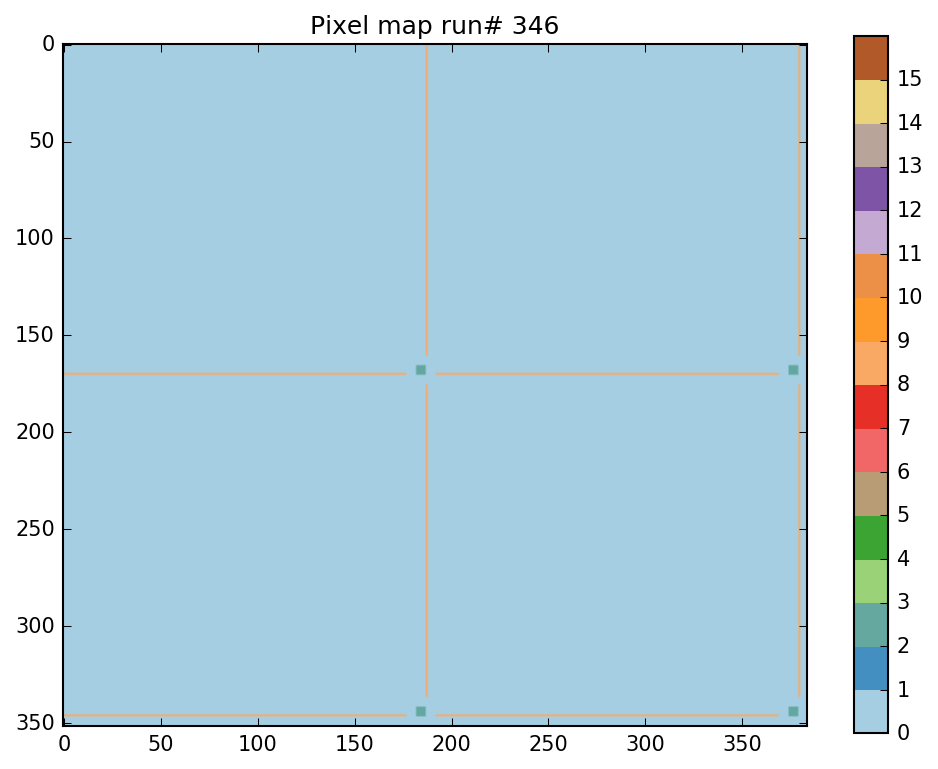

Epix10ka_0


### [Epix10ka_0] RUN 346 config ###
R0Mode: 1
SyncDelay: 30
SyncMode: 0
SyncWidth: 30
acqToAsicR0Delay: 14032
adcClkHalfT: 1
adcPipelineDelay: 32
adcPipelineDelay0: 32
adcPipelineDelay1: 32
adcPipelineDelay2: 32
adcPipelineDelay3: 32
adcReadsPerPixel: 1
adcStreamMode: 0
analogCardId0: 3000428033
analogCardId1: 905969689
asicAcq: 0
asicAcqControl: 0
asicAcqLToPPmatL: 200
asicAcqWidth: 2500
asicGR: 0
asicGRControl: 0
asicMask: 15
asicPPmatToReadout: 0
asicPpbe: 0
asicPpbeControl: 0
asicPpmat: 1
asicPpmatControl: 1
asicR0: 0
asicR0ClkControl: 0
asicR0Control: 0
asicR0ToAsicAcq: 10000
asicR0Width: 30
asicRoClk: 0
asicRoClkHalfT: 5
asics_shape: [4]
baseClockFrequency: 1048576
calibPixelConfigArray: [[3 3 3 3 3 3 3 0 3 0 3 0 3 0 0 3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0
  3 3 0 3 3 3 3 0 3 3 0 3 0 3 3 0 3 3 0 0 3 0 0 3 0 0 0 3 3 3 0 0 0 0 3 0 3
  3 3 3 3 0 0 3 0 3 0 3 3 3 0 0 3 3 0 3 0 0 0 3 3 3 3 3 3 3 0 3 0 3 0 3 0 0
  3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0 3 3 0 3 3 

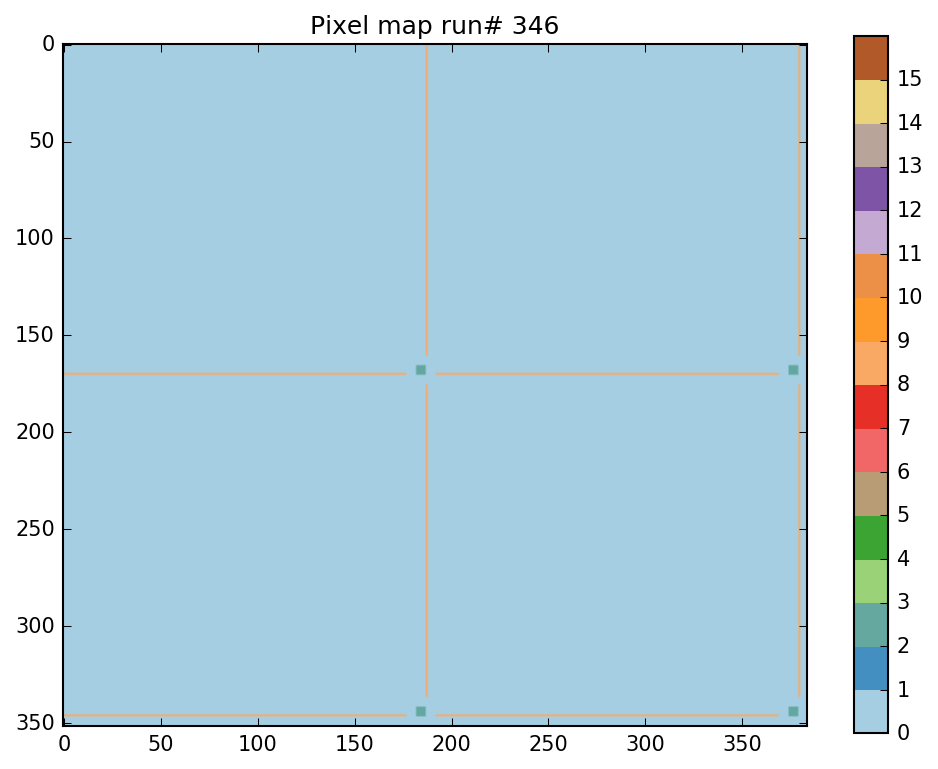

last two rows
Epix10ka_0:
(M=0) average calib row 176 (baseline) is 2412.190833, std is 173.631708
(M=0) average calib row 177 (pixelmax) is 16382.564957, std is 8.446490
(M=1) average calib row 177 (baseline) is 2433.853932, std is 170.926871
(M=1) average calib row 176 (pixelmax) is 16382.705518, std is 7.218007
Epix10ka_1:
(M=0) average calib row 176 (baseline) is 2437.020276, std is 169.684379
(M=0) average calib row 177 (pixelmax) is 16379.994210, std is 20.509140
(M=1) average calib row 177 (baseline) is 2430.936718, std is 170.746715
(M=1) average calib row 176 (pixelmax) is 16381.510933, std is 14.658479


In [23]:
import psana as pa
import Detector.PyDataAccess as pda
EXPSTR = 'exp=mfxx32516:run=%d:smd' % (RUN)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# calibPixelConfigArray
last2rows = []
ds = pa.DataSource(EXPSTR)
detNames = pa.DetNames()
for detname in detNames:
    sdet = detname[0].lower()
    if "epix10ka" in sdet:
        DETECTOR = detname[1]
        print(detname[1])
        src = pa.Source(DETECTOR)
        env = ds.env()
        config = env.configStore().get(pa.Epix.Config10kaV1, src)
        
        if not config:
            print('[%s] RUN %s, has no config\n\n' % (DETECTOR,RUN))
            postit = 0
        else:
            print('\n\n### [%s] RUN %s config ###' % (DETECTOR,RUN))
            for c in dir(config):
                # skip anything that starts with _
                if c[0] == "_":
                    continue
                # skip asics, we will traverse it later
                if c == "asics":
                    continue
                # get attr and check if it is callable
                v = getattr(config, c)
                if not callable(v):
                    continue
                # special cases
                if c.lower() == "asicPixelConfigArray".lower():
                    parr = v()
                    fig, ax = plt.subplots()
                    fig.set_dpi(150)
                    fig.set_size_inches(8, 6)
                    cax = ax.imshow(parr, vmin=0, vmax=16, cmap=discrete_cmap(16, 'Paired'))
                    ax.set_title('Pixel map run# %d' % (RUN))
                    cbar = fig.colorbar(cax, ticks=range(16))
                    cbar.ax.set_yticklabels(np.arange(0, 16, 1))
                    continue
                if c.lower() == "calibPixelConfigArray".lower():
                    last2rows.append(v())
            # print the value
                print("%s: %s" % (c, v()))

            for i in range(config.numberOfAsics()):
                print("\tasic%d:" % (i))
                aconf = config.asics(i)
                for c in dir(aconf):
                    if c[0] == "_":
                        continue
                    v = getattr(aconf, c)
                    if not callable(v):
                        continue
                    print("\t\t%s: %s" % (c, v()))
            plt.show()

print("last two rows")
for idx, lrows in enumerate(last2rows):
    # we will only check if the last two rows on all asics are equal.
    print("Epix10ka_%d:" % (epix10ka_active[idx]))
    if np.array_equal(lrows[0], lrows[1]):
        calib0 = np.argwhere(lrows[0] == 0).ravel()
        calib1 = np.argwhere(np.bitwise_and(lrows[0],0x2) == 2).ravel()
        
        epix10ka_calibd = dfile['/Epix10ka_%d/calib' % (epix10ka_active[idx])]
        calcol0_bl = epix10ka_calibd[:,0:1,calib0] & 0x3FFF # row 176 is baseline
        calcol0_mx = epix10ka_calibd[:,2:3,calib0] & 0x3FFF # row 177 is max
        
        calcol1_mx = epix10ka_calibd[:,0:1,calib1] & 0x3FFF # rows are flipped
        calcol1_bl = epix10ka_calibd[:,2:3,calib1] & 0x3FFF
        
        calcol0_bl_flat = calcol0_bl.ravel()
        calcol0_mx_flat = calcol0_mx.ravel()
        calcol1_bl_flat = calcol1_bl.ravel()
        calcol1_mx_flat = calcol1_mx.ravel()
        print("(M=0) average calib row 176 (baseline) is %f, std is %f" % (calcol0_bl_flat.mean(), calcol0_bl_flat.std()))
        print("(M=0) average calib row 177 (pixelmax) is %f, std is %f" % (calcol0_mx_flat.mean(), calcol0_mx_flat.std()))
        
        print("(M=1) average calib row 177 (baseline) is %f, std is %f" % (calcol1_bl_flat.mean(), calcol1_bl_flat.std()))
        print("(M=1) average calib row 176 (pixelmax) is %f, std is %f" % (calcol1_mx_flat.mean(), calcol1_mx_flat.std()))
    else:
        print("TODO: row patterns are not equal")

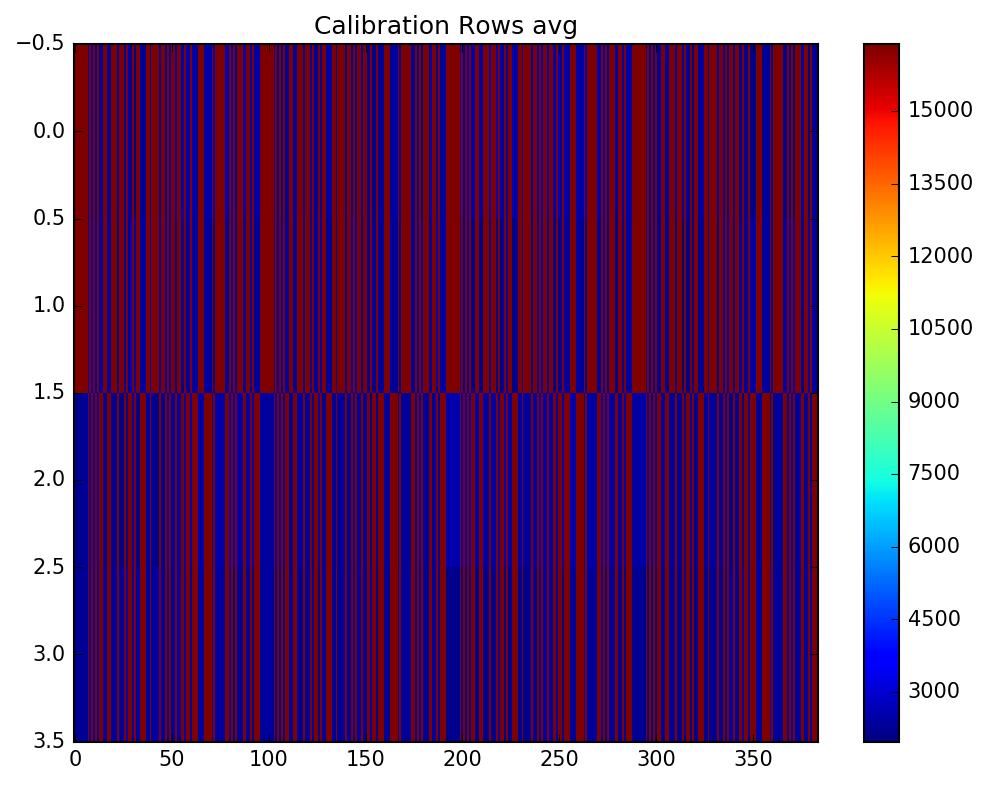

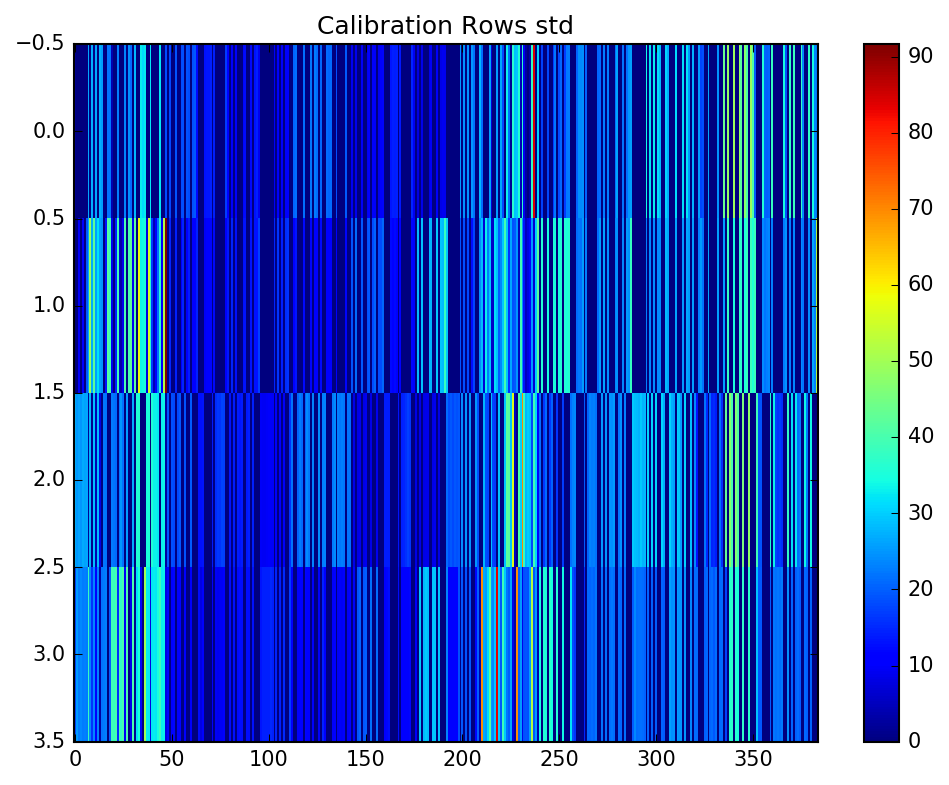

In [47]:
epix10ka_calibd = dfile['/Epix10ka_%d/calib' % (0)]
calibrows = epix10ka_calibd[:] & 0x3FFF

calibrows[:, 1, :] = np.roll(calibrows[:, 1, :], 48)
calibrows[:, 3, :] = np.roll(calibrows[:, 3, :], 48)

plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows avg')
plt.imshow(np.average(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows std')
plt.imshow(np.std(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

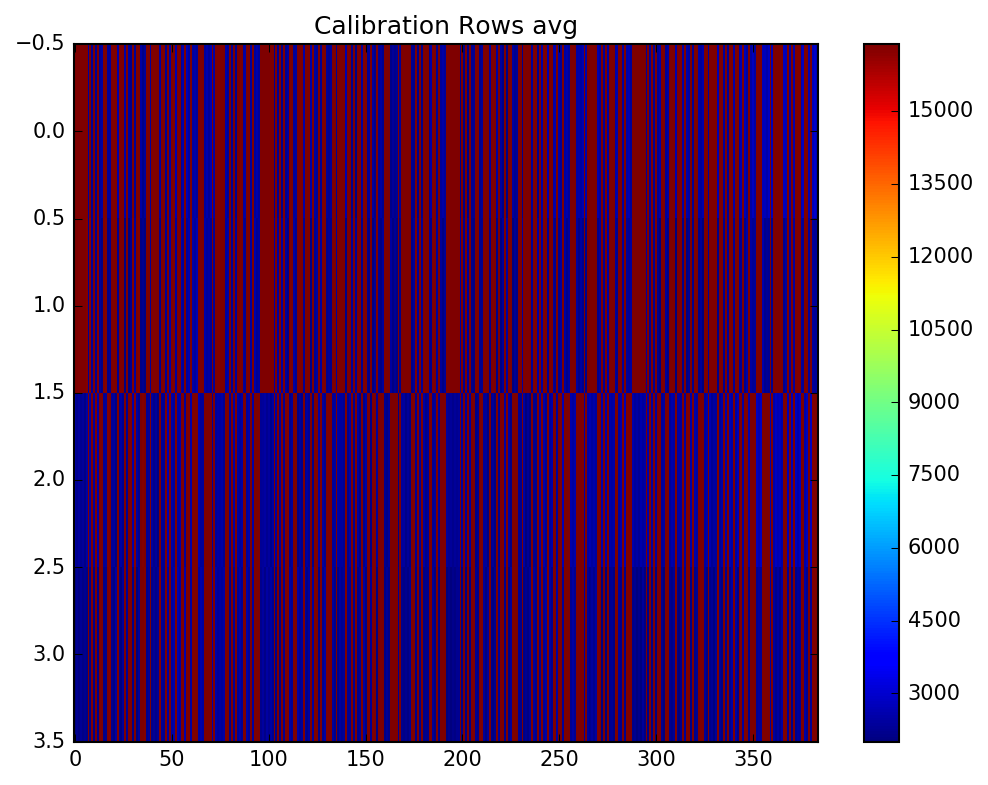

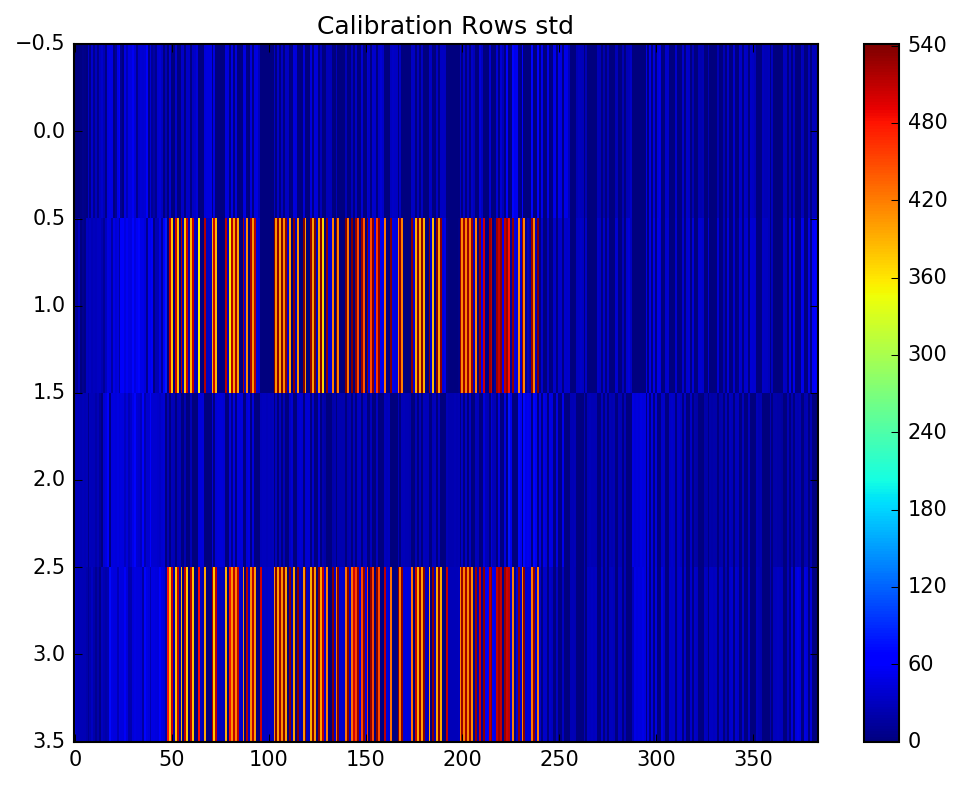

In [48]:
epix10ka_calibd = dfile['/Epix10ka_%d/calib' % (1)]
calibrows = epix10ka_calibd[:] & 0x3FFF

calibrows[:, 1, :] = np.roll(calibrows[:, 1, :], 48)
calibrows[:, 3, :] = np.roll(calibrows[:, 3, :], 48)

plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows avg')
plt.imshow(np.average(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows std')
plt.imshow(np.std(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()